In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###### Import csv and convert Date column to datetime, and set as index.

In [2]:
df = pd.read_csv('prices.csv', parse_dates=['Date'], index_col=['Date'])

###### Filter to price and quantity of similar items, and separate periods of time.

In [3]:
df = df.filter(items=['Regulus Price', 'Regulus Quantity Listed', 'Bast Price', 'Bast Quantity Listed', 'Wood Price', 'Wood Quantity Listed', 'Ochre Price', 'Ochre Quantity Listed', 'Resin Price', 'Resin Quantity Listed', 'Rune Price', 'Rune Quantity Listed'])
df = df.dropna()
df_2020 = df.loc['2020':'2021']
df_2022 = df.loc['2022':]

In [ ]:
### lol um

In [45]:
### plt.subplots(figsize=(15, 10))
### df_2020['Wood Price'].plot(kind='line', marker='o', color='sienna')
### df_2020['Wood Quantity Listed'].plot(kind='bar', color='tan')

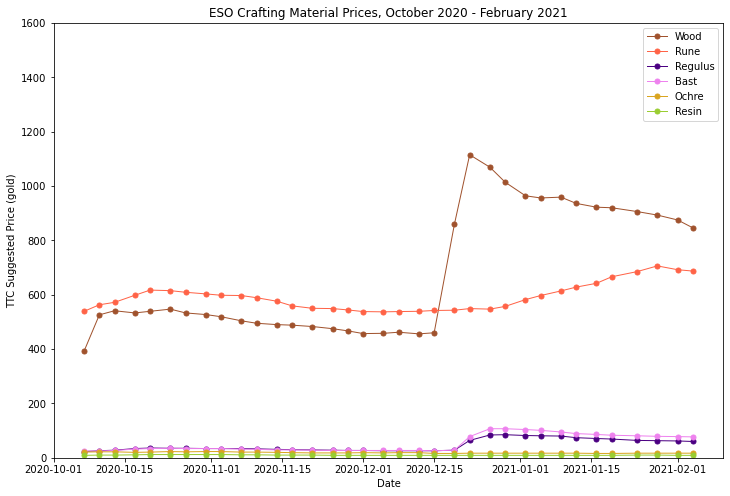

In [39]:
plt.plot(df_2020['Wood Price'], label='Wood', linewidth=1, marker='.', markersize=10, color='sienna')
plt.plot(df_2020['Rune Price'], label='Rune', linewidth=1, marker='.', markersize=10, color='tomato')
plt.plot(df_2020['Regulus Price'], label='Regulus', linewidth=1, marker='.', markersize=10, color='indigo')
plt.plot(df_2020['Bast Price'], label='Bast', linewidth=1, marker='.', markersize=10, color='violet')
plt.plot(df_2020['Ochre Price'], label='Ochre', linewidth=1, marker='.', markersize=10, color='goldenrod')
plt.plot(df_2020['Resin Price'], label='Resin', linewidth=1, marker='.', markersize=10, color='yellowgreen')
plt.ylabel('TTC Suggested Price (gold)')
plt.xlabel('Date')
plt.title('ESO Crafting Material Prices, October 2020 - February 2021')
plt.legend(loc="upper right")
plt.ylim([0, 1600])
plt.gcf().set_size_inches(12, 8)
plt.show()

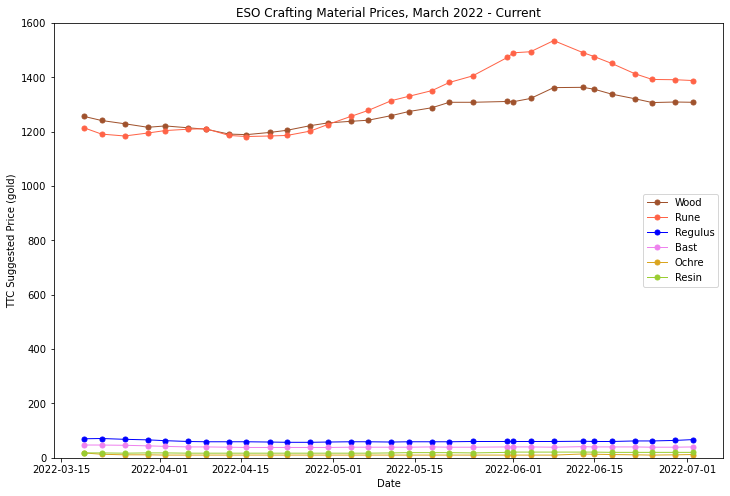

In [37]:
plt.plot(df_2022['Wood Price'], label='Wood', linewidth=1, marker='.', markersize=10, color='sienna')
plt.plot(df_2022['Rune Price'], label='Rune', linewidth=1, marker='.', markersize=10, color='tomato')
plt.plot(df_2022['Regulus Price'], label='Regulus', linewidth=1, marker='.', markersize=10, color='indigo')
plt.plot(df_2022['Bast Price'], label='Bast', linewidth=1, marker='.', markersize=10, color='violet')
plt.plot(df_2022['Ochre Price'], label='Ochre', linewidth=1, marker='.', markersize=10, color='goldenrod')
plt.plot(df_2022['Resin Price'], label='Resin', linewidth=1, marker='.', markersize=10, color='yellowgreen')
plt.ylabel('TTC Suggested Price (gold)')
plt.xlabel('Date')
plt.title('ESO Crafting Material Prices, March 2022 - Current')
plt.legend(loc="right")
plt.ylim([0, 1600])
plt.gcf().set_size_inches(12, 8)
plt.show()

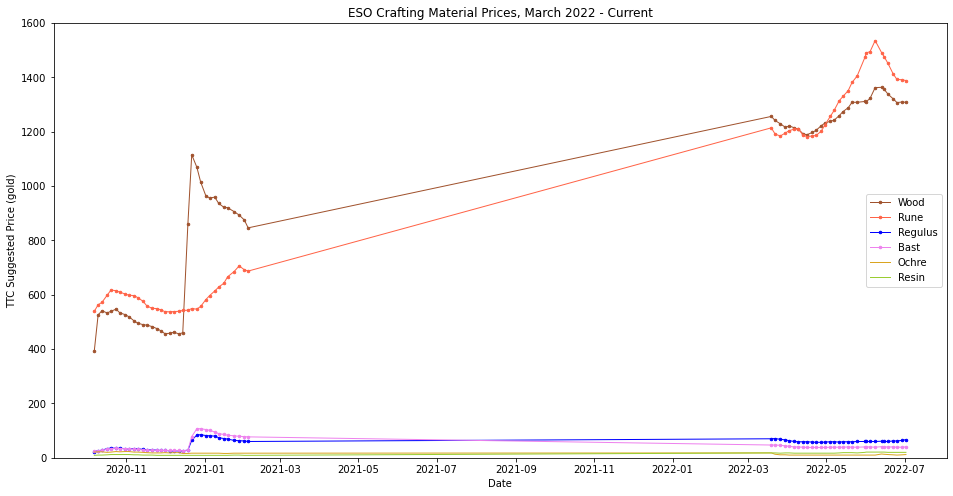

In [36]:
plt.plot(df['Wood Price'], label='Wood', linewidth=1, marker='.', markersize=5, color='sienna')
plt.plot(df['Rune Price'], label='Rune', linewidth=1, marker='.', markersize=5, color='tomato')
plt.plot(df['Regulus Price'], label='Regulus', linewidth=1, marker='.', markersize=5, color='indigo')
plt.plot(df['Bast Price'], label='Bast', linewidth=1, marker='.', markersize=5, color='violet')
plt.plot(df['Ochre Price'], label='Ochre', linewidth=1, color='goldenrod')
plt.plot(df['Resin Price'], label='Resin', linewidth=1, color='yellowgreen')
plt.ylabel('TTC Suggested Price (gold)')
plt.xlabel('Date')
plt.title('ESO Crafting Material Prices, March 2022 - Current')
plt.legend(loc="right")
plt.ylim([0, 1600])
plt.gcf().set_size_inches(16, 8)
plt.show()